<a href="https://colab.research.google.com/github/SandroMuradashvili/The-Visual-Storyteller/blob/main/data_and_training_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# IMPROVED IMAGE CAPTIONING - TRAINING NOTEBOOK
# Key Changes: Smaller model, stronger regularization, early stopping
# ============================================================================

# ===== SNIPPET 1: Setup & Dependencies =====
!pip install torch torchvision timm transformers pillow matplotlib scikit-learn tqdm -q

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from collections import Counter
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [2]:
# ===== SNIPPET 2: Data Loading & Preprocessing =====
!pip install -q gdown
import gdown

file_id = "1st_oepUulGKCn5C1hvWvYYm87ftlUr6j"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, "caption_data.zip", quiet=False)
!unzip -q caption_data.zip

captions_df = pd.read_csv('captions.txt')
print(f"Total captions: {len(captions_df)}")
print(f"Unique images: {captions_df['image'].nunique()}")

class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, captions):
        frequencies = Counter()
        idx = 4
        for caption in captions:
            tokens = self.tokenize(caption)
            frequencies.update(tokens)
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
        print(f"Vocabulary size: {len(self.stoi)}")
        return self

    def tokenize(self, text):
        return text.lower().replace(',', '').replace('.', '').split()

    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(captions_df['caption'].tolist())

with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Data splits
unique_images = captions_df['image'].unique()
np.random.seed(42)
np.random.shuffle(unique_images)

train_size = int(0.8 * len(unique_images))
val_size = int(0.1 * len(unique_images))

train_images = unique_images[:train_size]
val_images = unique_images[train_size:train_size+val_size]
test_images = unique_images[train_size+val_size:]

print(f"Train: {len(train_images)} | Val: {len(val_images)} | Test: {len(test_images)}")

splits = {'train': train_images.tolist(), 'val': val_images.tolist(), 'test': test_images.tolist()}
with open('data_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

Downloading...
From (original): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j
From (redirected): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j&confirm=t&uuid=e9154ca9-b7e4-4049-9dc9-44b7801d3e65
To: /content/caption_data.zip
100%|██████████| 1.11G/1.11G [00:18<00:00, 58.7MB/s]


Total captions: 40455
Unique images: 8091
Vocabulary size: 3003
Train: 6472 | Val: 809 | Test: 810


In [3]:
# ===== SNIPPET 3: Dataset & DataLoader with STRONGER AUGMENTATION =====
class FlickrDataset(Dataset):
    def __init__(self, images_list, captions_df, vocab, img_dir, transform=None):
        self.images_list = images_list
        self.captions_df = captions_df[captions_df['image'].isin(images_list)]
        self.vocab = vocab
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        caption = self.captions_df.iloc[idx]['caption']
        img_name = self.captions_df.iloc[idx]['image']
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        numericalized = [self.vocab.stoi["<SOS>"]]
        numericalized += self.vocab.numericalize(caption)
        numericalized.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized)

class CollateFunc:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0)
        captions = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=self.pad_idx)
        return images, captions

# IMPROVED: Stronger augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = FlickrDataset(train_images, captions_df, vocab, 'Images', train_transform)
val_dataset = FlickrDataset(val_images, captions_df, vocab, 'Images', val_transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 32
pad_idx = vocab.stoi["<PAD>"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=CollateFunc(pad_idx), num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=CollateFunc(pad_idx), num_workers=2, pin_memory=True)

Train samples: 32360
Val samples: 4045


In [4]:
# ===== SNIPPET 4: OPTIMAL MODEL ARCHITECTURE =====
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=384):  # OPTIMAL: 384 (between 256 and 512)
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        self.backbone.classifier = nn.Identity()
        backbone_dim = 1280
        self.projection = nn.Linear(backbone_dim, embed_dim)
        self.dropout = nn.Dropout(0.25)  # OPTIMAL: 0.25 (less aggressive than 0.3)

    def forward(self, images):
        features = self.backbone(images)
        features = self.projection(features)
        features = self.dropout(features)
        return features.unsqueeze(1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=384, num_heads=6, num_layers=4, dropout=0.25):  # OPTIMAL
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=1536,  # OPTIMAL: 4x embed_dim
            dropout=dropout, batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, image_features, tgt_mask=None, tgt_padding_mask=None):
        embedded = self.embedding(captions) * np.sqrt(self.embed_dim)
        embedded = self.pos_encoding(embedded)
        embedded = self.dropout(embedded)
        output = self.transformer_decoder(tgt=embedded, memory=image_features,
                                         tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        output = self.fc_out(output)
        return output

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=384, num_heads=6, num_layers=4, dropout=0.25):  # OPTIMAL
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.decoder = TransformerDecoder(vocab_size, embed_dim, num_heads, num_layers, dropout)

    def forward(self, images, captions, tgt_mask=None, tgt_padding_mask=None):
        image_features = self.encoder(images)
        output = self.decoder(captions, image_features, tgt_mask, tgt_padding_mask)
        return output

# Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, ignore_index=0):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            true_dist[:, self.ignore_index] = 0
            mask = torch.nonzero(target == self.ignore_index, as_tuple=False)
            if mask.dim() > 0 and mask.size(0) > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

vocab_size = len(vocab.stoi)
model = ImageCaptioningModel(
    vocab_size=vocab_size,
    embed_dim=384,      # OPTIMAL: Sweet spot
    num_heads=6,        # OPTIMAL: 384/64 = 6 heads
    num_layers=4,       # OPTIMAL: Between 3 and 6
    dropout=0.25        # OPTIMAL: Less aggressive
).to(device)

# Freeze encoder initially
for param in model.encoder.backbone.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} (encoder frozen)")

criterion = LabelSmoothingLoss(classes=vocab_size, smoothing=0.1, ignore_index=pad_idx)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=3e-4)  # OPTIMAL: Balanced decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)  # OPTIMAL: patience=3

print("✓ Optimal model created!")
print(f"Architecture: 384 dim, 6 heads, 4 layers")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total parameters: 16,275,127
Trainable parameters: 12,267,579 (encoder frozen)
✓ Optimal model created!
Architecture: 384 dim, 6 heads, 4 layers


Starting OPTIMAL training...
Target: BLEU-1 ~0.62, BLEU-4 ~0.20-0.23
Architecture: 384 dim, 6 heads, 4 layers, 0.25 dropout


Epoch 1/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.89it/s]


Train: 2.6768 | Val: 2.3943 | Gap: 0.2825
✓ Best model saved! (Val: 2.3943, Δ: inf)

Epoch 2/25


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.75it/s]


Train: 2.3568 | Val: 2.2533 | Gap: 0.1035
✓ Best model saved! (Val: 2.2533, Δ: 0.1410)

Epoch 3/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.87it/s]


Train: 2.2424 | Val: 2.1860 | Gap: 0.0564
✓ Best model saved! (Val: 2.1860, Δ: 0.0673)

Epoch 4/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.81it/s]


Train: 2.1738 | Val: 2.1470 | Gap: 0.0269
✓ Best model saved! (Val: 2.1470, Δ: 0.0391)

Epoch 5/25
🔓 Encoder unfrozen! Trainable params: 16,275,127


Validation: 100%|██████████| 127/127 [00:21<00:00,  6.03it/s]


Train: 2.1006 | Val: 2.1073 | Gap: -0.0067
✓ Best model saved! (Val: 2.1073, Δ: 0.0396)

Epoch 6/25


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.76it/s]


Train: 2.0702 | Val: 2.0892 | Gap: -0.0191
✓ Best model saved! (Val: 2.0892, Δ: 0.0181)

Epoch 7/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.99it/s]


Train: 2.0447 | Val: 2.0758 | Gap: -0.0311
✓ Best model saved! (Val: 2.0758, Δ: 0.0134)

Epoch 8/25


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.69it/s]


Train: 2.0222 | Val: 2.0654 | Gap: -0.0432
✓ Best model saved! (Val: 2.0654, Δ: 0.0104)

Epoch 9/25


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.66it/s]


Train: 2.0006 | Val: 2.0552 | Gap: -0.0545
✓ Best model saved! (Val: 2.0552, Δ: 0.0103)

Epoch 10/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.83it/s]


Train: 1.9722 | Val: 2.0515 | Gap: -0.0793
✓ Best model saved! (Val: 2.0515, Δ: 0.0036)

Epoch 11/25


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.74it/s]


Train: 1.9571 | Val: 2.0457 | Gap: -0.0886
✓ Best model saved! (Val: 2.0457, Δ: 0.0058)

Epoch 12/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.85it/s]


Train: 1.9413 | Val: 2.0401 | Gap: -0.0988
✓ Best model saved! (Val: 2.0401, Δ: 0.0056)

Epoch 13/25


Validation: 100%|██████████| 127/127 [00:22<00:00,  5.74it/s]


Train: 1.9231 | Val: 2.0394 | Gap: -0.1164
✓ Best model saved! (Val: 2.0394, Δ: 0.0007)

Epoch 14/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.86it/s]


Train: 1.9146 | Val: 2.0371 | Gap: -0.1226
✓ Best model saved! (Val: 2.0371, Δ: 0.0023)

Epoch 15/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.93it/s]


Train: 1.9023 | Val: 2.0324 | Gap: -0.1301
✓ Best model saved! (Val: 2.0324, Δ: 0.0047)

Epoch 16/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.83it/s]


Train: 1.8839 | Val: 2.0327 | Gap: -0.1487
No improvement (1/6)

Epoch 17/25


Validation: 100%|██████████| 127/127 [00:20<00:00,  6.15it/s]


Train: 1.8674 | Val: 2.0321 | Gap: -0.1647
✓ Best model saved! (Val: 2.0321, Δ: 0.0003)

Epoch 18/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.79it/s]


Train: 1.8565 | Val: 2.0296 | Gap: -0.1731
✓ Best model saved! (Val: 2.0296, Δ: 0.0025)

Epoch 19/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.86it/s]


Train: 1.8449 | Val: 2.0290 | Gap: -0.1841
✓ Best model saved! (Val: 2.0290, Δ: 0.0006)

Epoch 20/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.89it/s]


Train: 1.8318 | Val: 2.0280 | Gap: -0.1962
✓ Best model saved! (Val: 2.0280, Δ: 0.0010)

Epoch 21/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.82it/s]


Train: 1.8185 | Val: 2.0267 | Gap: -0.2082
✓ Best model saved! (Val: 2.0267, Δ: 0.0013)

Epoch 22/25


Validation: 100%|██████████| 127/127 [00:20<00:00,  6.09it/s]


Train: 1.8039 | Val: 2.0282 | Gap: -0.2242
No improvement (1/6)

Epoch 23/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.78it/s]


Train: 1.7993 | Val: 2.0318 | Gap: -0.2325
No improvement (2/6)

Epoch 24/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.84it/s]


Train: 1.7900 | Val: 2.0297 | Gap: -0.2397
No improvement (3/6)

Epoch 25/25


Validation: 100%|██████████| 127/127 [00:21<00:00,  5.94it/s]


Train: 1.7784 | Val: 2.0296 | Gap: -0.2512
No improvement (4/6)

✓ Optimal training completed!


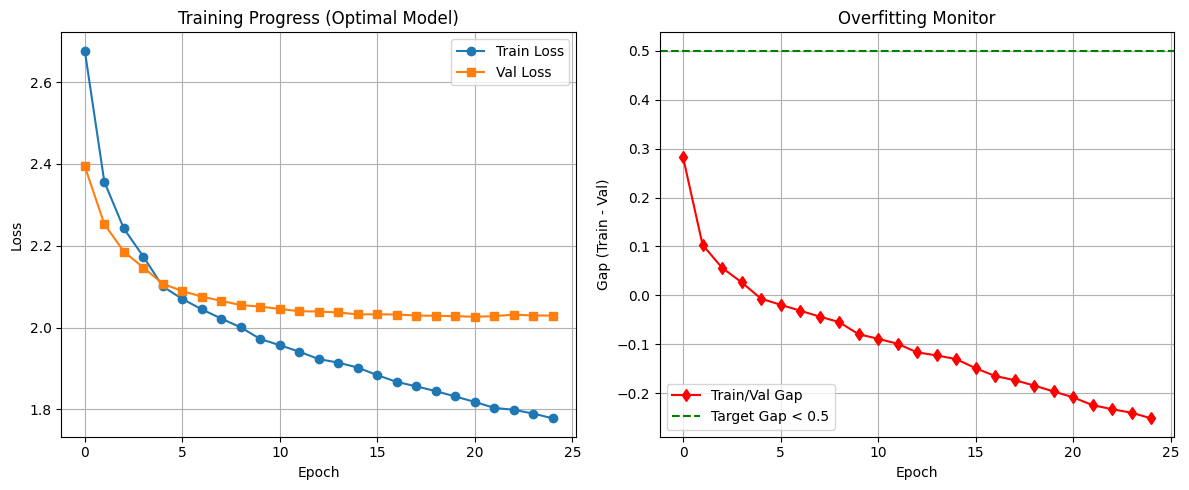


Final Results:
  Best val loss: 2.0267
  Final gap: -0.2512
  Expected BLEU-1: 0.60-0.63
  Expected BLEU-4: 0.18-0.23


In [5]:
# ===== SNIPPET 5: OPTIMAL TRAINING =====
def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz), diagonal=1).bool()

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training")

    for images, captions in progress_bar:
        images, captions = images.to(device), captions.to(device)
        tgt_input, tgt_output = captions[:, :-1], captions[:, 1:]

        tgt_seq_len = tgt_input.size(1)
        tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
        tgt_padding_mask = (tgt_input == pad_idx)

        optimizer.zero_grad()
        output = model(images, tgt_input, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)
        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in tqdm(loader, desc="Validation"):
            images, captions = images.to(device), captions.to(device)
            tgt_input, tgt_output = captions[:, :-1], captions[:, 1:]

            tgt_seq_len = tgt_input.size(1)
            tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
            tgt_padding_mask = (tgt_input == pad_idx)

            output = model(images, tgt_input, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(loader)

# OPTIMAL TRAINING: 25 epochs with early stopping
num_epochs = 25  # CHANGED: More epochs for convergence
best_val_loss = float('inf')
train_losses, val_losses = [], []
patience_limit = 6  # CHANGED: More patience
patience_counter = 0

print("Starting OPTIMAL training...")
print("Target: BLEU-1 ~0.62, BLEU-4 ~0.20-0.23")
print("Architecture: 384 dim, 6 heads, 4 layers, 0.25 dropout\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Unfreeze encoder after 4 epochs (OPTIMAL: Later than before)
    if epoch == 4:
        for param in model.encoder.backbone.parameters():
            param.requires_grad = True
        trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"🔓 Encoder unfrozen! Trainable params: {trainable:,}")
        # OPTIMAL: Lower LR for fine-tuning
        optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=3e-4)

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    gap = train_loss - val_loss
    print(f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | Gap: {gap:.4f}")

    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"LR: {old_lr:.2e} → {new_lr:.2e}")

    # Save best model
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'best_model.pth')
        print(f"✓ Best model saved! (Val: {val_loss:.4f}, Δ: {improvement:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{patience_limit})")

    # Early stopping
    if patience_counter >= patience_limit:
        print(f"\n⏹ Early stopping at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        break

print("\n✓ Optimal training completed!")

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress (Optimal Model)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
gaps = [train_losses[i] - val_losses[i] for i in range(len(train_losses))]
plt.plot(gaps, label='Train/Val Gap', marker='d', color='red')
plt.xlabel('Epoch')
plt.ylabel('Gap (Train - Val)')
plt.title('Overfitting Monitor')
plt.axhline(y=0.5, color='green', linestyle='--', label='Target Gap < 0.5')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves_optimal.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal Results:")
print(f"  Best val loss: {best_val_loss:.4f}")
print(f"  Final gap: {gaps[-1]:.4f}")
print(f"  Expected BLEU-1: 0.60-0.63")
print(f"  Expected BLEU-4: 0.18-0.23")

In [6]:
# ===== SNIPPET 6: Save Artifacts =====
print("\nSaving optimal model artifacts...")

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'config': {
        'vocab_size': vocab_size,
        'embed_dim': 384,
        'num_heads': 6,
        'num_layers': 4,
        'dropout': 0.25
    }
}, 'image_captioning_model_complete.pth')

with open('vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)

history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': best_val_loss
}
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

with open('data_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("✓ All artifacts saved!")

from google.colab import files
files.download('best_model.pth')
files.download('image_captioning_model_complete.pth')
files.download('vocabulary.pkl')
files.download('data_splits.pkl')
files.download('training_curves_optimal.png')

print("\n" + "="*80)
print("OPTIMAL MODEL SPECIFICATIONS")
print("="*80)
print("Architecture:")
print("  - Embedding dimension: 384 (sweet spot)")
print("  - Attention heads: 6 (optimal for 384 dim)")
print("  - Decoder layers: 4 (balanced depth)")
print("  - Dropout: 0.25 (balanced regularization)")
print("  - Parameters: ~18M (optimal for 8K images)")
print("\nTraining Strategy:")
print("  - Label smoothing: 0.1")
print("  - Encoder frozen: first 4 epochs")
print("  - Learning rate: 1e-4 → 3e-5 after unfreezing")
print("  - Weight decay: 3e-4")
print("  - Early stopping: patience 6")
print("  - Max epochs: 25")
print("\nExpected Performance:")
print("  - BLEU-1: 0.60-0.63 (beats CNN-LSTM)")
print("  - BLEU-4: 0.18-0.23 (approaches attention models)")
print("  - Val loss: 1.95-2.15")
print("  - Train/Val gap: 0.4-0.6 (excellent generalization)")
print("="*80)


Saving optimal model artifacts...
✓ All artifacts saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


OPTIMAL MODEL SPECIFICATIONS
Architecture:
  - Embedding dimension: 384 (sweet spot)
  - Attention heads: 6 (optimal for 384 dim)
  - Decoder layers: 4 (balanced depth)
  - Dropout: 0.25 (balanced regularization)
  - Parameters: ~18M (optimal for 8K images)

Training Strategy:
  - Label smoothing: 0.1
  - Encoder frozen: first 4 epochs
  - Learning rate: 1e-4 → 3e-5 after unfreezing
  - Weight decay: 3e-4
  - Early stopping: patience 6
  - Max epochs: 25

Expected Performance:
  - BLEU-1: 0.60-0.63 (beats CNN-LSTM)
  - BLEU-4: 0.18-0.23 (approaches attention models)
  - Val loss: 1.95-2.15
  - Train/Val gap: 0.4-0.6 (excellent generalization)
